In [1]:
import numpy as np
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import os
import sys
import pickle
from struct import *
import pandas as pd
import seaborn as sns
import mixture
sns.set_style("white")
import warnings
warnings.filterwarnings("ignore")
import collections
from math import pi, cos, sin, cosh, tanh
from scipy.spatial.transform import Rotation as Rot

In [2]:
import scipy.interpolate
import scipy.integrate
import scipy.stats
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.signal import argrelextrema

## Define the functions for calibration

In [3]:
def build_poly(X, Y):  # villanueva
    P = np.array([X**2, Y**2, X, Y, X*Y, np.ones(len(X))]).T
    return P


# Ficks Angle Conversions
def vec2ficks(x, y, z):
    '''
    Calculate ficks angles, corresponding to the given vector, conveniently labelled azimuth and polar angle.
    
    Ficks angles are based on nested gimbals, where the outer gimbal is rotated first about the 
    vertical axis (az) and then about the now rotated horizontal (shoulder) axis (pol). Ficks is normally
    (as here) described using passive rotations, where the second rotation is around an axis rotated 
    by the first rotation. It can, however, be described using active rotations, where the rotation axes are
    fixed in world coordinates; to do so the two rotations are applied in the opposite direction.
    
    Thus, in terms of world coordinates, calculating the resulting gaze vector using the two Ficks
    angles can be calculated as follows:
    
        (x, y, z) = np.dot(rotmat.R('y', az), np.dot(rotmat.R('x', pol), np.array([0, 0, 1])))
        
    or equivalently
    
        (x, y, z) = np.dot(np.matmul(rotmat.R('y', az), rotmat.R('x', pol)), np.array([0, 0, 1])))
        
    where x is the shoulder axis, y the vertical axis and z represents the line of sight.
    
    (Haslwanter, T. (1995). Mathematics of three-dimensional eye rotations. Vision research, 35(12), 1727-1739.)

    Note that a 3D vector cannot represent a torsion component, so only 2 Ficks angles are returned here.

    This that the calculation here is identical to converting to "adapted 2 spherical coordinates, for 
    which the formula used is based on e.g. https://web.physics.ucsb.edu/~fratus/phys103/Disc/disc_notes_3_pdf.pdf, 
    just adapted to conventional gaze concepts where the polar angle is 0 at the center coordinate
    and azimuth increases in the direction of x, counting from z.

    '''
    r = np.sqrt(x**2 + y**2 + z**2)
    az = np.arctan2(x , z) # Note: If we had done az = 90 - np.arccos(x / r) we would return visual angles
    pol = np.arccos(y / r)

    return np.rad2deg(az), 90 - np.rad2deg(pol)

## Collect varjo data across all participants
Create a separate csv file per task. Remember to calibrate the data using the appropriate C.csv files.

In [4]:
# All participants and their respective vision loss
participants = {'P2':'CVL', 'P3':'CVL', 'P4':'Other', 'P5':'PVL', 'P6':'CVL', 'P8':'CVL', 'P9':'CVL', 'P10':'CVL',
                'P11':'PVL', 'P12':'PVL', 'P13':'CVL', 'P14':'PVL', 'P15':'PVL', 'P16':'PVL', 'P17':'PVL',
                'P18':'CVL', 'P19':'PVL', 'P21':'CVL', 'P22':'PVL', 'P23':'PVL', 'P24':'PVL', 'P25':'CVL'}

varjo_data = {'cereal':{}, 'sandwich':{}, 'hand_wash':{}}
C = {'cereal':{}, 'sandwich':{}, 'hand_wash':{}}

for participant in participants.keys():
    recordingFolder = '/data/Isabella/thesis_spring2022/AMPs2_varjo/{subID}/'.format(subID=participant)
    try:
        os.listdir(recordingFolder)
    except:
        continue
    
    for task in os.listdir(recordingFolder):
        for fname in os.listdir(recordingFolder+task):
            if fname == 'C.csv':
                C[task][participant] = recordingFolder+task+'/'+fname
            else:
                try:
                    varjo_data[task][participant].append(recordingFolder+task+'/'+fname)
                    varjo_data[task][participant].sort()
                except:
                    varjo_data[task][participant] = [recordingFolder+task+'/'+fname]
            
                
print("Number of gaze files across all participants:", sum([len(list(d.values())) for d in list(varjo_data.values())]))

Number of gaze files across all participants: 55


In [5]:
varjo_data

{'cereal': {'P2': ['/data/Isabella/thesis_spring2022/AMPs2_varjo/P2/cereal/varjo_gaze_output_2022-02-04_14-38-42-103.csv'],
  'P3': ['/data/Isabella/thesis_spring2022/AMPs2_varjo/P3/cereal/varjo_gaze_output_2022-02-10_10-38-06-418.csv'],
  'P4': ['/data/Isabella/thesis_spring2022/AMPs2_varjo/P4/cereal/varjo_gaze_output_2022-02-14_10-11-48-204.csv'],
  'P5': ['/data/Isabella/thesis_spring2022/AMPs2_varjo/P5/cereal/varjo_gaze_output_2022-02-08_10-22-45-519.csv'],
  'P6': ['/data/Isabella/thesis_spring2022/AMPs2_varjo/P6/cereal/varjo_gaze_output_2022-02-10_15-06-06-750.csv'],
  'P8': ['/data/Isabella/thesis_spring2022/AMPs2_varjo/P8/cereal/varjo_gaze_output_2022-02-03_11-04-58-394.csv'],
  'P9': ['/data/Isabella/thesis_spring2022/AMPs2_varjo/P9/cereal/varjo_gaze_output_2022-02-04_10-26-52-492.csv'],
  'P10': ['/data/Isabella/thesis_spring2022/AMPs2_varjo/P10/cereal/varjo_gaze_output_2022-01-31_13-58-57-031.csv'],
  'P13': ['/data/Isabella/thesis_spring2022/AMPs2_varjo/P13/cereal/varjo_gaz

In [6]:
# create one csv file for each task across all participants
for task, v in varjo_data.items():
    
    df = pd.DataFrame({'subID':[],
                       'raw_timestamp':[],
                       'right_forward_x':[],
                       'right_forward_y':[],
                       'right_forward_z':[],
                       'left_forward_x':[],
                       'left_forward_y':[],
                       'left_forward_z':[],
                       'right_x_deg_calib':[],
                       'right_y_deg_calib':[],
                       'left_x_deg_calib':[],
                       'left_y_deg_calib':[]})

    for subID, fnames in v.items():
        vision_loss = participants[subID]
        
        temp = pd.read_csv(fnames[0])
        temp['subID'] = subID
        
        # combine data for experiments with multiple files for one task
        if len(fnames) > 1:
            for i in range(1, len(fnames)):
                t = pd.read_csv(fnames[i])
                t['subID'] = subID
                temp = pd.concat([temp, t])
        
        temp.reset_index(inplace=True)
        
        # account for negative time offset (gaze data starts before video, so they need to be aligned) 
        vid_time = temp['relative_to_video_first_frame_timestamp'].to_numpy()
        time = temp['raw_timestamp'].to_numpy()
        time = (time-time[0])*10**-9 # from nanoseconds to seconds
        time = time-(0.0-vid_time[0])*10**-9
        
        # first convert to angular (ficks) degrees
        right_x_deg, right_y_deg = vec2ficks(temp.right_forward_x, temp.right_forward_y, temp.right_forward_z)
        left_x_deg, left_y_deg = vec2ficks(temp.left_forward_x, temp.left_forward_y, temp.left_forward_z)

        # build the polynomial for each eye
        P_right = build_poly(right_x_deg, right_y_deg)
        P_left = build_poly(left_x_deg, left_y_deg)
        
        # calibrate to get adjusted gaze angles
        calib = pd.read_csv(C[task][subID])
        right_x_deg_calib, right_y_deg_calib = (np.dot(P_right, calib.Right_cX), np.dot(P_right, calib.Right_cY))
        left_x_deg_calib, left_y_deg_calib = (np.dot(P_left, calib.Left_cX), np.dot(P_left, calib.Left_cY))
        
        
        df = pd.concat([df, pd.DataFrame({'subID':temp.subID.values,
                                          'raw_timestamp':temp.raw_timestamp.values,
                                          'time(s)':time,
                                          'right_forward_x':temp.right_forward_x.values,
                                          'right_forward_y':temp.right_forward_y.values,
                                          'right_forward_z':temp.right_forward_z.values,
                                          'left_forward_x':temp.left_forward_x.values,
                                          'left_forward_y':temp.left_forward_y.values,
                                          'left_forward_z':temp.left_forward_z.values,
                                          'right_x_deg_calib':right_x_deg_calib,
                                          'right_y_deg_calib':right_y_deg_calib,
                                          'left_x_deg_calib':left_x_deg_calib,
                                          'left_y_deg_calib':left_y_deg_calib})])
            
        
            
    # Export full event sequence
    out_path = '/data/Isabella/thesis_spring2022/AMPs2_varjo/'+task+'_all.csv'
    df.to_csv(out_path)

<IPython.core.display.Javascript object>


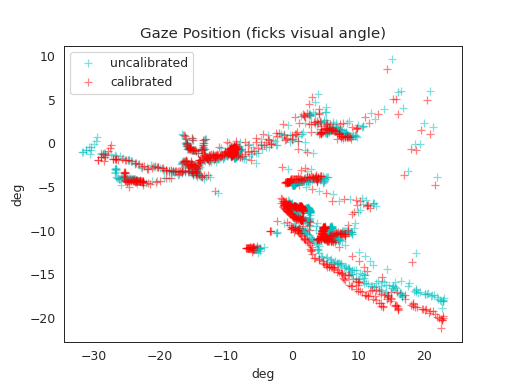

In [7]:
# Calibration output test
df = pd.read_csv('/data/Isabella/thesis_spring2022/AMPs2_varjo/sandwich_all.csv')
df = df[df.subID=='P2']

x, y = vec2ficks(df.right_forward_x, df.right_forward_y, df.right_forward_z)

start_i, end_i = 0, 1000

plt.figure()
plt.title('Gaze Position (ficks visual angle)')
plt.plot(x[start_i:end_i], y[start_i:end_i], 'c+', alpha=0.5, label='uncalibrated')
plt.plot(df.right_x_deg_calib[start_i:end_i], df.right_y_deg_calib[start_i:end_i], 'r+', alpha=0.5, label='calibrated')
plt.legend()
plt.xlabel('deg')
plt.ylabel('deg')
plt.show()